<a href="https://colab.research.google.com/github/catastropiyush/TransformerAsOn/blob/master/Phase_Transition_LLMs_Unsloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [4]:
import os
import json
import time
import numpy as np
from datasets import load_dataset
from unsloth import FastLanguageModel
import torch
import random

# Create output directories
os.makedirs("/content/outputs", exist_ok=True)

model_name = "unsloth/Llama-3.2-3B-Instruct"

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Load the dataset
print("Loading dataset...")
ds = load_dataset("sentence-transformers/simple-wiki")

# Initialize model with Unsloth
print(f"Loading {model_name}...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=2048,
    load_in_4bit=True,  # Use 4-bit quantization to reduce memory
    device_map="auto",
)
print("Model loaded successfully")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Loading dataset...


README.md:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/102225 [00:00<?, ? examples/s]

Loading unsloth/Llama-3.2-3B-Instruct...
==((====))==  Unsloth 2025.3.15: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

Model loaded successfully


In [14]:
def gen_with_T(T, max_tokens=1024):  # Reduced max_tokens for faster generation
    T = float("%.4f" % (T))

    model_family = model_name.split("/")[0]
    file_prefix = model_name.split("/")[-1]

    # Store outputs locally in Colab
    output_dir = f"/content/outputs/{model_family}"
    os.makedirs(output_dir, exist_ok=True)
    fname = f"{output_dir}/{file_prefix}-T{T}.json"

    if os.path.exists(fname):
        print(f"{fname} already exists, skipping")
        return

    try:
        # Take a very small subset for debugging
        sample_texts = [i for i in ds['train']['text']][::5000][:5]  #samples for testing
        print(f"Processing {len(sample_texts)} samples with temperature {T}")
        data = []

        for i, prompt in enumerate(sample_texts):
            print(f"  Processing sample {i+1}/{len(sample_texts)}")
            # Format prompt for Gemma instruction format
            formatted_prompt = f"<start_of_turn>user\n{prompt[:500]}<end_of_turn>\n<start_of_turn>model\n"  # Limit input length

            # Configure generation parameters
            inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

            # Generate with Unsloth (removed seed from parameters)
            start_time = time.time()
            print(f"  Starting generation...")
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_tokens,
                    min_new_tokens=10,  # Reduced min tokens
                    temperature=T if T > 0 else 1.0,
                    do_sample=T > 0,
                    num_return_sequences=1,
                    pad_token_id=tokenizer.eos_token_id
                )
            print(f"  Generation completed in {time.time() - start_time:.2f} seconds")

            # Extract generated text
            generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

            # Remove any trailing <end_of_turn> token if present
            if "<end_of_turn>" in generated_text:
                generated_text = generated_text.split("<end_of_turn>")[0].strip()

            data.append({
                "prompt": prompt[:500],  # Limit prompt length in output
                "generated": generated_text
            })

        with open(fname, "w") as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        print(f"saved to {fname}")

    except Exception as e:
        print(f"Error generating with T={T}: {e}")
        import traceback
        traceback.print_exc()

In [18]:
if __name__ == "__main__":
    #gen_with_T(0.8)
    # for T in [0.0, 2.0, 4.0]:
    #     gen_with_T(T)
     for T in np.linspace(0,10,5):
         gen_with_T(T)

     print("\nGenerated files:")
     os.system("ls -R /content/outputs")

Processing 5 samples with temperature 0.0
  Processing sample 1/5
  Starting generation...
  Generation completed in 42.18 seconds
  Processing sample 2/5
  Starting generation...
  Generation completed in 40.34 seconds
  Processing sample 3/5
  Starting generation...
  Generation completed in 12.64 seconds
  Processing sample 4/5
  Starting generation...
  Generation completed in 40.45 seconds
  Processing sample 5/5
  Starting generation...
  Generation completed in 39.91 seconds
saved to /content/outputs/unsloth/Llama-3.2-3B-Instruct-T0.0.json
Processing 5 samples with temperature 2.5
  Processing sample 1/5
  Starting generation...
  Generation completed in 40.65 seconds
  Processing sample 2/5
  Starting generation...
  Generation completed in 40.33 seconds
  Processing sample 3/5
  Starting generation...
  Generation completed in 40.25 seconds
  Processing sample 4/5
  Starting generation...
  Generation completed in 40.86 seconds
  Processing sample 5/5
  Starting generation...


In [19]:
import os
import re
import math
import json
import numpy as np
from matplotlib import pyplot as plt

import torch
from tqdm import tqdm
from unsloth import FastModel

# Create output directories
os.makedirs("/content/data", exist_ok=True)
os.makedirs("/content/plots", exist_ok=True)

# Assuming the Unsloth model is already loaded
# You would typically have these variables already defined:
# model_name = "unsloth/gemma-3-4b-it"
# model, tokenizer = FastModel.from_pretrained(...)

# Get the model_name from environment if not already set
model_name = os.getenv("model_name", "unsloth/Llama-3.2-3B-Instruct")
print("using %s"%(model_name))

# No need to load the model again if it's already loaded
# If model and tokenizer aren't already defined, you'd uncomment these:
# tokenizer = model.tokenizer  # Unsloth models have tokenizer attached
# embed_tokens = model.model.get_input_embeddings()

# Function to access the embeddings from a loaded Unsloth model
def get_embed_tokens(model):
    # For Unsloth model, we need to access the underlying model
    if hasattr(model, 'model') and hasattr(model.model, 'get_input_embeddings'):
        return model.model.get_input_embeddings()
    elif hasattr(model, 'get_input_embeddings'):
        return model.get_input_embeddings()
    else:
        raise AttributeError("Could not find embedding layer in the model")

def get_files(dir, file_perfix):
    text_files = []
    try:
        for i in os.listdir("/content/outputs/%s"%(dir)):
            r = re.search("%s-T([0-9\.]+?)\.json"%(file_perfix), i)
            if not r:
                continue
            T = float(r.group(1))
            text_files.append({
                "T": T,
                "path": "/content/outputs/%s/%s"%(dir,i)
            })
        text_files.sort(key=lambda x: x["T"])
    except FileNotFoundError:
        print(f"Directory '/content/outputs/{dir}' not found. Make sure you've generated output files.")
    return text_files

def load_json(filename):
    if os.path.exists(filename):
        with open(filename, "r") as f:
            data = json.load(f)
    else:
        data = {}
    return data

def add_log(filename, entry, data):
    json_data = load_json(filename)
    if entry not in json_data:
        json_data[entry] = data
    else:
        json_data[entry] = {**json_data[entry], **data}

    lines = []
    for k, v in json_data.items():
        lines.append("\"%s\": %s"%(k, json.dumps(v)))
    with open(filename, "w") as f:
        f.write("{\n")
        f.write(",\n".join(lines))
        f.write("\n}")

def energy(filename, model, tokenizer):
    with open(filename, "r") as f:
        data = json.load(f)

    embed_tokens = get_embed_tokens(model)

    with torch.no_grad():
        energies = []
        lengths  = []
        for d in tqdm(data, desc="Computing energies"):
            # Ensure we're only analyzing the generated text, not the prompt
            text = d["generated"]

            model_inputs = tokenizer(text, return_tensors="pt").to(model.device)
            inputs_embeds = embed_tokens(model_inputs["input_ids"]) # 1, len, dim
            inputs_embeds = inputs_embeds.squeeze(0)

            # Normalize the embeddings
            inputs_embeds /= torch.linalg.vector_norm(inputs_embeds, dim=-1, keepdim=True)

            # Compute attention/energy matrix
            attn = -inputs_embeds @ inputs_embeds.T  # attn[i,j] = ei cdot ej
            attn.fill_diagonal_(0.0)

            # Compute energy
            e = (attn.sum()/attn.shape[0]).item()
            energies.append(e)
            lengths.append(attn.shape[0])

    print("avg length for %s: %.2f"%(filename, np.mean(lengths)))
    return np.mean(energies), np.std(energies)/math.sqrt(len(data))

def susceptibility(filename, model, tokenizer):
    with open(filename, "r") as f:
        data = json.load(f)

    embed_tokens = get_embed_tokens(model)
    N = 512  # Number of tokens to analyze

    with torch.no_grad():
        spins = []
        for d in tqdm(data, desc="Computing susceptibilities"):
            # Process only the generated text
            text = d["generated"]

            model_inputs = tokenizer(text, return_tensors="pt").to(model.device)
            inputs_embeds = embed_tokens(model_inputs["input_ids"])  # 1, len, dim
            inputs_embeds = inputs_embeds.squeeze(0)

            # Normalize embeddings
            inputs_embeds /= torch.linalg.vector_norm(inputs_embeds, dim=-1, keepdim=True)

            # Take the last N tokens or all if less than N
            last_n = min(N, inputs_embeds.shape[0])
            spins.append(inputs_embeds[-last_n:, :])

    # Stack and compute mean
    spins = torch.cat(spins, dim=0)  # Combine all spins
    if spins.shape[0] > N:
        spins = spins[:N]  # Take only first N spins

    spinsbar = torch.mean(spins, dim=0, keepdim=True)
    deltaspins = spins - spinsbar  # Fluctuations around mean

    # Compute correlations
    sisj = []
    for i in range(spins.shape[0]):
        for j in range(i+1, spins.shape[0]):
            si_sj = torch.sum(deltaspins[i] * deltaspins[j]).item()
            sisj.append(si_sj)

    return np.mean(sisj)

def plot_energy(model, tokenizer, plot_flag=True):
    # Extract model family and name for file paths
    dir = model_name.split("/")[0]  # unsloth
    file_perfix = model_name.split("/")[-1]  # gemma-3-4b-it

    text_files = get_files(dir, file_perfix)

    if not text_files:
        print(f"No output files found for {model_name}. Make sure generation has completed.")
        return

    betas, energies, sigmas = [], [], []
    for i in text_files:
        T, path = i["T"], i["path"]
        print(f"Processing temperature T={T} from {path}")
        e, s = energy(path, model, tokenizer)
        betas.append(T)
        energies.append(e)
        sigmas.append(s)

    print("Temperatures and energies:")
    print(list(zip(betas, [float("%.2f"%(e)) for e in energies])))

    # Save energy data
    energy_file = f"/content/data/{dir}-energy.json"

    # Get model size if possible
    model_size = 0
    try:
        if hasattr(model, 'model'):
            model_size = sum(p.numel() for p in model.model.parameters() if p.requires_grad)
        else:
            model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
    except:
        print("Could not determine model size")

    add_log(energy_file, file_perfix, {
        "model_size": model_size,
        "betas": betas,
        "energies": energies,
        "sigmas": sigmas
    })

    if not plot_flag:
        return

    # Create plot
    Tmin = min(betas)
    Tmax = max(betas)

    plt.figure(figsize=(10, 6))
    plt.errorbar(betas, energies, yerr=sigmas, capsize=2)
    plt.minorticks_on()
    plt.xlabel("Temperature")
    plt.ylabel("Energy")
    plt.title(f"{file_perfix} Energy vs Temperature")
    plt.tight_layout()

    plot_path = f"/content/plots/energy_{file_perfix}-{Tmin:.1f}-{Tmax:.1f}.pdf"
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")

    plt.show()

# Usage example (uncomment and fill in your model and tokenizer variables)
# plot_energy(model, tokenizer)

# To run the analysis, you would do:
#
#
# Make sure 'model' and 'tokenizer' are your loaded Unsloth model and tokenizer
# You can also run the susceptibility analysis separately:
# dir = model_name.split("/")[0]
# file_perfix = model_name.split("/")[-1]
# text_files = get_files(dir, file_perfix)
# for i in text_files:
#     T, path = i["T"], i["path"]
#     sus = susceptibility(path, model, tokenizer)
#     print(f"Temperature {T}, Susceptibility: {sus}")

print("\nTo run the analysis, execute:")
print("plot_energy(model, tokenizer)")

using unsloth/Llama-3.2-3B-Instruct

To run the analysis, execute:
plot_energy(model, tokenizer)


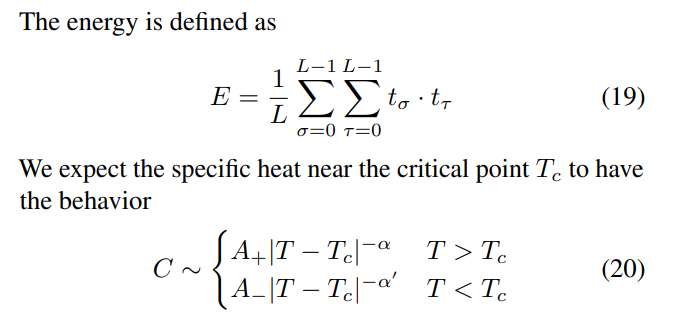

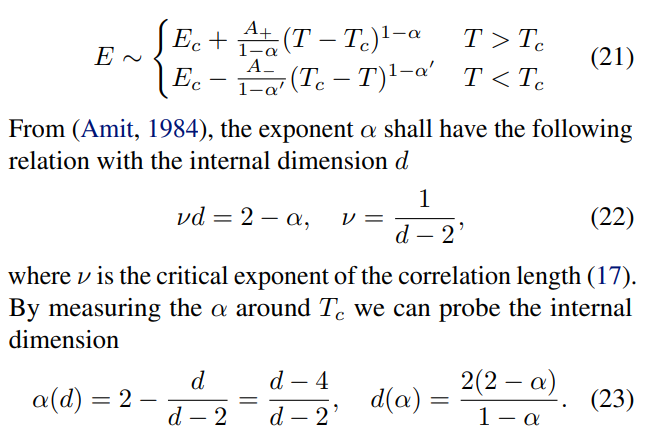

Processing temperature T=0.0 from /content/outputs/unsloth/Llama-3.2-3B-Instruct-T0.0.json


Computing energies: 100%|██████████| 5/5 [00:00<00:00, 964.03it/s]


avg length for /content/outputs/unsloth/Llama-3.2-3B-Instruct-T0.0.json: 38.40
Processing temperature T=2.5 from /content/outputs/unsloth/Llama-3.2-3B-Instruct-T2.5.json


Computing energies: 100%|██████████| 5/5 [00:00<00:00, 296.30it/s]


avg length for /content/outputs/unsloth/Llama-3.2-3B-Instruct-T2.5.json: 427.80
Processing temperature T=5.0 from /content/outputs/unsloth/Llama-3.2-3B-Instruct-T5.0.json


Computing energies: 100%|██████████| 5/5 [00:00<00:00, 274.40it/s]


avg length for /content/outputs/unsloth/Llama-3.2-3B-Instruct-T5.0.json: 1007.00
Processing temperature T=7.5 from /content/outputs/unsloth/Llama-3.2-3B-Instruct-T7.5.json


Computing energies: 100%|██████████| 5/5 [00:00<00:00, 236.95it/s]


avg length for /content/outputs/unsloth/Llama-3.2-3B-Instruct-T7.5.json: 1011.40
Processing temperature T=10.0 from /content/outputs/unsloth/Llama-3.2-3B-Instruct-T10.0.json


Computing energies: 100%|██████████| 5/5 [00:00<00:00, 270.24it/s]

avg length for /content/outputs/unsloth/Llama-3.2-3B-Instruct-T10.0.json: 1003.40
Temperatures and energies:
[(0.0, -2.2), (2.5, -inf), (5.0, -inf), (7.5, -inf), (10.0, -inf)]


Plot saved to /content/plots/energy_Llama-3.2-3B-Instruct-0.0-10.0.pdf


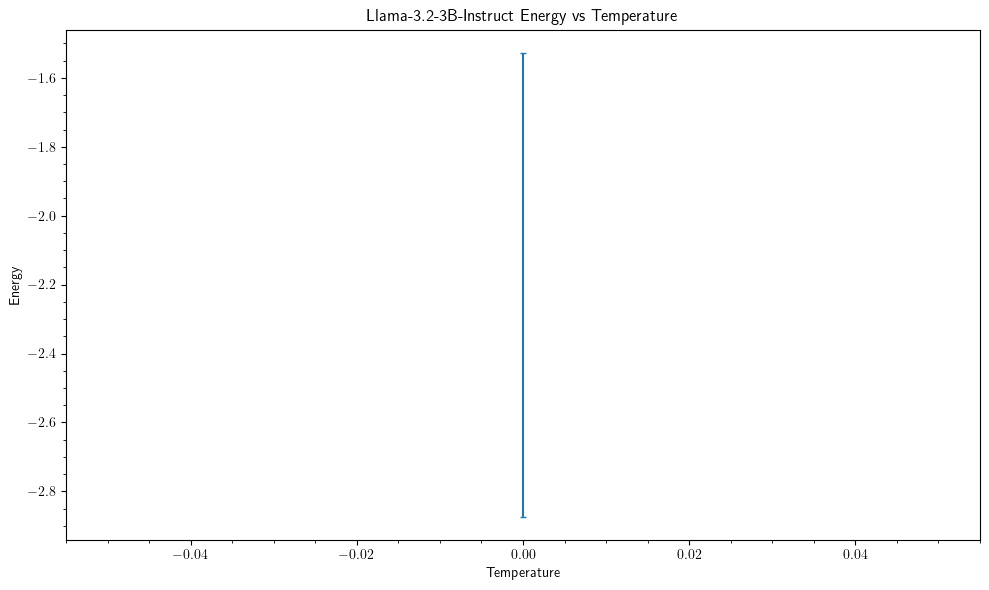

In [20]:
plot_energy(model, tokenizer)

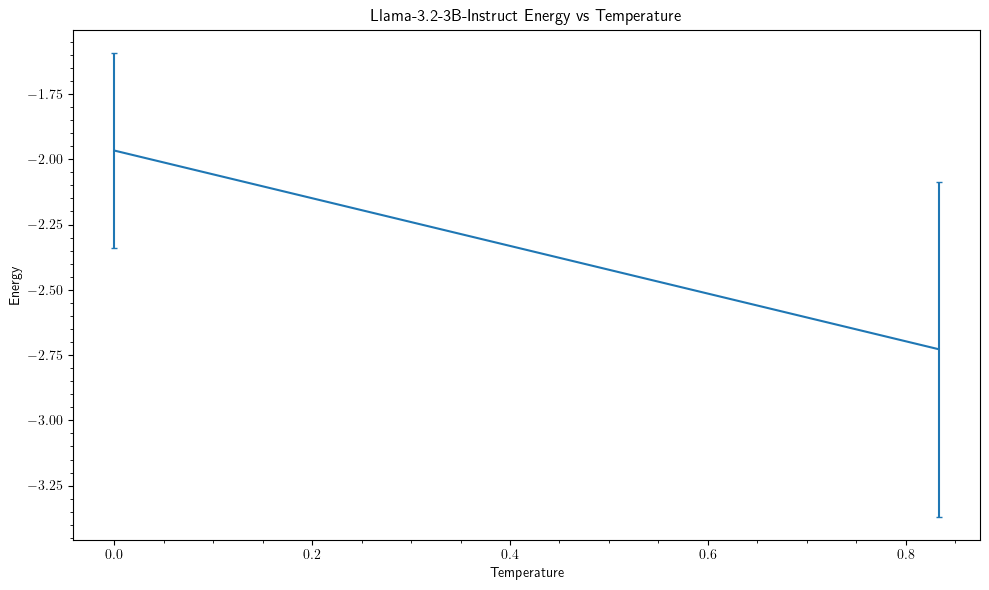